In [1229]:
import pandas as pd
import numpy as np
import csv
import sys
import scipy
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.model_selection import learning_curve
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
#from textblob.taggers import NLTKTagger

## Reading data - csv file using pandas

In [1230]:
adv=pd.read_csv('fakerealnews.csv')

## How the data frame looks like

In [1231]:
adv.shape

(2353, 2)

## First 10 values of data frame

In [1232]:
adv.head(10)

,label,news
0,FAKE,You Can Smell Hillary’s Fear
1,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,REAL,Kerry to go to Paris in gesture of sympathy
3,FAKE,Bernie supporters on Twitter erupt in anger ag...
4,REAL,The Battle of New York: Why This Primary Matters
5,FAKE,"Tehran, USA"
6,FAKE,Girl Horrified At What She Watches Boyfriend D...
7,REAL,‘Britain’s Schindler’ Dies at 106
8,REAL,Fact check: Trump and Clinton at the 'commande...
9,REAL,Iran reportedly makes new push for uranium con...


## value counts- Returns object containing counts of unique values.

In [1233]:
adv.news.value_counts()

OnPolitics | 's politics blog                                                                         3
Michael Moore Owes Me $4.99                                                                           3
The Israeli Trumpess                                                                                  2
Clintons Are Under Multiple FBI Investigations as Agents Are Stymied                                  2
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence    2
                                                                                                     ..
Obamacare Is Back At The Supreme Court, And These 6 Lives Hang In The Balance                         1
Even Democratic Voters Don’t Trust Hillary                                                            1
Baltimore protests: Crowds stand firm after curfew                                                    1
New Study Links Fluoride Consumption To Hypothyroidism, Weight G

In [1234]:
adv.label.value_counts()

FAKE    1206
REAL    1147
Name: label, dtype: int64

## Aggregate statistics

In [1235]:
adv.describe()

,label,news
count,2353,2353
unique,2,2338
top,FAKE,OnPolitics | 's politics blog
freq,1206,3


In [1236]:
adv.groupby('label').describe()

news                                           
      count unique                            top freq
label                                                 
FAKE   1206   1196    Michael Moore Owes Me $4.99    3
REAL   1147   1142  OnPolitics | 's politics blog    3

## Removing Null values- Cleaning the data

In [1237]:
adv[adv.news.notnull()]
adv[adv.label.notnull()]

,label,news
0,FAKE,You Can Smell Hillary’s Fear
1,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,REAL,Kerry to go to Paris in gesture of sympathy
3,FAKE,Bernie supporters on Twitter erupt in anger ag...
4,REAL,The Battle of New York: Why This Primary Matters
...,...,...
2348,REAL,Marco Rubio: Critics of Immigration Bill Were ...
2349,REAL,Bernie Sanders win this way: Why his admirable...
2350,FAKE,'Russia has no intention of attacking anyone -...
2351,FAKE,Iceland Election: Pirate Party prepares for ma...


## Verifying the Null values -

In [1238]:
adv=adv[pd.notnull(adv['news'])]
adv=adv[pd.notnull(adv['label'])]

In [1239]:
adv.isnull()

,label,news
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
2348,False,False
2349,False,False
2350,False,False
2351,False,False


## Length Calculation

In [1240]:
adv['length']=adv['news'].map(lambda text: len(text))
adv.head(5)

,label,news,length
0,FAKE,You Can Smell Hillary’s Fear,28
1,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,85
2,REAL,Kerry to go to Paris in gesture of sympathy,43
3,FAKE,Bernie supporters on Twitter erupt in anger ag...,84
4,REAL,The Battle of New York: Why This Primary Matters,48


## Plotting the graph according 

<AxesSubplot:ylabel='Frequency'>

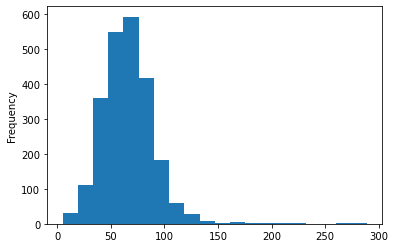

In [1241]:
adv.length.plot(bins=20, kind='hist')

In [1242]:
adv.length.describe()

count    2353.000000
mean       65.914152
std        24.402665
min         5.000000
25%        50.000000
50%        64.000000
75%        79.000000
max       289.000000
Name: length, dtype: float64

## Data Preprocessing

In [1243]:
def tokenize(text):
    news2 = 'text -' + str(text)  # convert bytes into proper unicode
    return TextBlob(text).words

In [1244]:
adv.news.head().apply(tokenize)

0               [You, Can, Smell, Hillary, ’, s, Fear]
1    [Watch, The, Exact, Moment, Paul, Ryan, Commit...
2    [Kerry, to, go, to, Paris, in, gesture, of, sy...
3    [Bernie, supporters, on, Twitter, erupt, in, a...
4    [The, Battle, of, New, York, Why, This, Primar...
Name: news, dtype: object

In [1245]:
def lemmatize(news):
    text2 = 'text -' + str(news).lower()
    words = TextBlob(news).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

adv.news.head().apply(lemmatize)

0               [You, Can, Smell, Hillary, ’, s, Fear]
1    [Watch, The, Exact, Moment, Paul, Ryan, Commit...
2    [Kerry, to, go, to, Paris, in, gesture, of, sy...
3    [Bernie, supporter, on, Twitter, erupt, in, an...
4    [The, Battle, of, New, York, Why, This, Primar...
Name: news, dtype: object

## Data to Vectors- fitting and transforming using Count Vectorizer 

In [1246]:
bow_transformer=CountVectorizer(analyzer=lemmatize).fit(adv['news'])
len(bow_transformer.vocabulary_)

7599

In [1247]:
news4=adv['news'][100]
news4

'How Ted Cruz Became Ted Cruz'

In [1248]:
bow4 = bow_transformer.transform([news4])
bow4

<1x7599 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [1249]:
bow4.shape

(1, 7599)

In [1250]:
news_bow = bow_transformer.transform(adv['news'])

'sparsity: %.2f%%' % (100.0 * news_bow.nnz / (news_bow.shape[0] * news_bow.shape[1]))

'sparsity: 0.14%'

In [1251]:
'sparse matrix shape:', news_bow.shape


('sparse matrix shape:', (2353, 7599))

In [1252]:
'number of non-zeros:', news_bow.nnz

('number of non-zeros:', 25610)

## Data to Vectors- fitting and transforming TFIDF- term frequency- inverse doc frequency and getting sparse matrix

In [1253]:
tfidf_transformer = TfidfTransformer().fit(news_bow)
tfidf4 = tfidf_transformer.transform(bow4)
tfidf4

<1x7599 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [1254]:
news_tfidf = tfidf_transformer.transform(news_bow)
news_tfidf.shape

(2353, 7599)

## Applying Algorithms on the whole data set and predicting accuracy

## MultinomialNB

In [1255]:
%time spam_detector = MultinomialNB().fit(news_tfidf, adv['label'])

CPU times: user 14.6 ms, sys: 4.91 ms, total: 19.5 ms
Wall time: 28.7 ms


In [1256]:
spam_detector=MultinomialNB().fit(news_tfidf, adv['label'])
spam_detector

MultinomialNB()

In [1257]:
all_predictions = spam_detector.predict(news_tfidf)
all_predictions

array(['FAKE', 'FAKE', 'REAL', ..., 'REAL', 'FAKE', 'REAL'], dtype='<U4')

In [1452]:
'accuracy', accuracy_score(adv['label'], all_predictions)
print('confusion matrix\n', confusion_matrix(adv['label'], all_predictions))
print('(row=expected, col=predicted)')

confusion matrix
 [[1204    2]
 [   1 1146]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

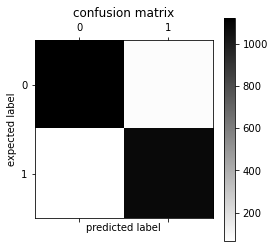

In [1259]:
plt.matshow(confusion_matrix(adv['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

## LR

In [1261]:
%time spam_detector = LogisticRegression().fit(news_tfidf, adv['label'])

CPU times: user 80 ms, sys: 13 ms, total: 93 ms
Wall time: 89.2 ms


In [1262]:
spam_detector=LogisticRegression().fit(news_tfidf, adv['label'])
spam_detector

LogisticRegression()

In [1263]:
all_predictions = spam_detector.predict(news_tfidf)
all_predictions

array(['FAKE', 'FAKE', 'REAL', ..., 'FAKE', 'FAKE', 'REAL'], dtype=object)

In [1453]:
'accuracy', accuracy_score(adv['label'], all_predictions)
print('confusion matrix\n', confusion_matrix(adv['label'], all_predictions))
print('(row=expected, col=predicted)')

confusion matrix
 [[1204    2]
 [   1 1146]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

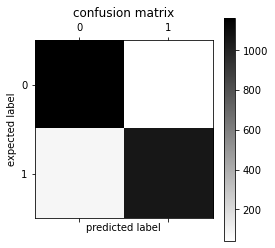

In [1265]:
plt.matshow(confusion_matrix(adv['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

## RF

In [1267]:
%time spam_detector = RandomForestClassifier().fit(news_tfidf, adv['label'])

CPU times: user 1.17 s, sys: 19.2 ms, total: 1.19 s
Wall time: 1.2 s


In [1268]:
spam_detector=RandomForestClassifier().fit(news_tfidf, adv['label'])
spam_detector

RandomForestClassifier()

In [1269]:
all_predictions = spam_detector.predict(news_tfidf)
all_predictions

array(['FAKE', 'FAKE', 'REAL', ..., 'FAKE', 'FAKE', 'REAL'], dtype=object)

In [1454]:
'accuracy', accuracy_score(adv['label'], all_predictions)
print('confusion matrix\n', confusion_matrix(adv['label'], all_predictions))
print('(row=expected, col=predicted)')

confusion matrix
 [[1204    2]
 [   1 1146]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

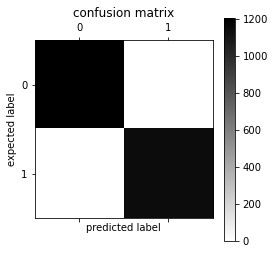

In [1271]:
plt.matshow(confusion_matrix(adv['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

## DT

In [1273]:
%time spam_detector = DecisionTreeClassifier().fit(news_tfidf, adv['label'])

CPU times: user 340 ms, sys: 4.16 ms, total: 344 ms
Wall time: 364 ms


In [1274]:
spam_detector=DecisionTreeClassifier().fit(news_tfidf, adv['label'])
spam_detector

DecisionTreeClassifier()

In [1275]:
all_predictions = spam_detector.predict(news_tfidf)
all_predictions

array(['FAKE', 'FAKE', 'REAL', ..., 'FAKE', 'FAKE', 'REAL'], dtype=object)

In [1457]:
'accuracy', accuracy_score(adv['label'], all_predictions)
print('confusion matrix\n', confusion_matrix(adv['label'], all_predictions))
print('(row=expected, col=predicted)')

confusion matrix
 [[1204    2]
 [   1 1146]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

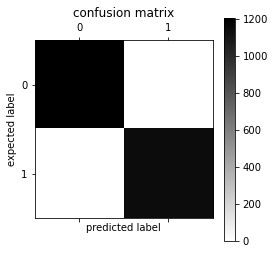

In [1277]:
plt.matshow(confusion_matrix(adv['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

## SVM

In [1279]:
%time spam_detector = SVC().fit(news_tfidf, adv['label'])

CPU times: user 736 ms, sys: 15.5 ms, total: 751 ms
Wall time: 766 ms


In [1280]:
spam_detector=SVC().fit(news_tfidf, adv['label'])
spam_detector

SVC()

In [1281]:
all_predictions = spam_detector.predict(news_tfidf)
all_predictions

array(['FAKE', 'FAKE', 'REAL', ..., 'FAKE', 'FAKE', 'REAL'], dtype=object)

In [1456]:
'accuracy', accuracy_score(adv['label'], all_predictions)
print('confusion matrix\n', confusion_matrix(adv['label'], all_predictions))
print('(row=expected, col=predicted)')

confusion matrix
 [[1204    2]
 [   1 1146]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

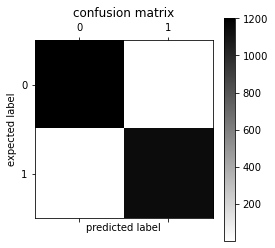

In [1283]:
plt.matshow(confusion_matrix(adv['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

## Calculating how much data we are training and testing

In [1285]:
msg_train, msg_test, label_train, label_test = train_test_split(adv['news'], adv['label'], test_size=0.2)

len(msg_train), len(msg_test), len(label_train) ,len(label_test)

(1882, 471, 1882, 471)

#### Resulted in 5% of testing data and rest is the training data

In [1286]:
import _pickle as cPickle

In [1287]:
from sklearn.model_selection import GridSearchCV

In [1288]:
vect=CountVectorizer()

In [1289]:
new_df1=adv[['news']]
new_df2=adv[['label']]

In [1290]:
train_data=new_df1.iloc[1:500,:]
test_data=new_df2.iloc[500:1,:]
train_label=new_df1.iloc[1:500,:]
test_label=new_df2.iloc[500:1,:]
train_vectors=vect.fit_transform(train_data)
test_vectors=vect.fit_transform(test_data)

In [1291]:
test_vectors.toarray()

array([[1]])

In [1292]:
test_vectors.toarray()


array([[1]])

In [1293]:
X=adv.news
y=adv.label

In [1294]:
print(X.shape)
print(y.shape)


(2353,)
(2353,)


In [1295]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test=train_test_split(X , y, test_size=0.25,random_state=0)

In [1296]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1764,)
(589,)
(1764,)
(589,)


In [1298]:
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<1764x5008 sparse matrix of type '<class 'numpy.int64'>'
	with 17891 stored elements in Compressed Sparse Row format>

In [1297]:
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [1299]:
X_test_dtm = vect.transform(X_test)

In [1300]:
X_test_dtm

<589x5008 sparse matrix of type '<class 'numpy.int64'>'
	with 5013 stored elements in Compressed Sparse Row format>

In [1301]:
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score
import sys
import scipy
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier


## Applying MACHINE LEARNING ALGORITHM ON TRAINING AND TESTING DATA

# Bagging Naive Bayes


In [1302]:
from sklearn.naive_bayes import MultinomialNB

In [1303]:
bagging_NB = BaggingClassifier(MultinomialNB(),
                            max_samples=0.5
                            , max_features=0.5)


In [1304]:
bagging_NB.fit(X_train_dtm , y_train)

BaggingClassifier(base_estimator=MultinomialNB(), max_features=0.5,
                  max_samples=0.5)

In [1305]:
y_pred_class=bagging_NB.predict(X_test_dtm)

In [1306]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[229,  47],
       [ 87, 226]])

In [1307]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 77.24957555178268


Text(0.5, 0, 'predicted label')

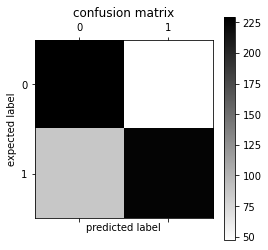

In [1308]:

plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1309]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.72      0.83      0.77       276
        REAL       0.83      0.72      0.77       313

    accuracy                           0.77       589
   macro avg       0.78      0.78      0.77       589
weighted avg       0.78      0.77      0.77       589



In [1310]:
scores = model_selection.cross_val_score(bagging_NB, X_train_dtm, y_train, cv = 3)


## AdaBoosting Naive Bayes

In [1311]:
adaboosting_NB = AdaBoostClassifier(base_estimator=MultinomialNB(),
                         n_estimators=500, 
                        learning_rate=1,
                        random_state=0)

In [1312]:
adaboosting_NB.fit(X_train_dtm , y_train)

AdaBoostClassifier(base_estimator=MultinomialNB(), learning_rate=1,
                   n_estimators=500, random_state=0)

In [1313]:
y_pred_class=adaboosting_NB.predict(X_test_dtm)


In [1314]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[233,  43],
       [ 88, 225]])

In [1315]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 77.75891341256367


Text(0.5, 0, 'predicted label')

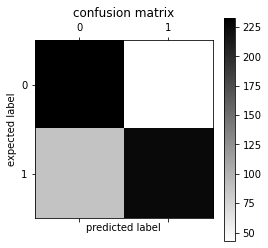

In [1316]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1317]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.73      0.84      0.78       276
        REAL       0.84      0.72      0.77       313

    accuracy                           0.78       589
   macro avg       0.78      0.78      0.78       589
weighted avg       0.79      0.78      0.78       589



## Gradient Boosting Naive Bayes

In [1318]:
grdboosting_NB = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, 
                                            max_features=2, max_depth=2, random_state=0)

In [1319]:
grdboosting_NB.fit(X_train_dtm , y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           n_estimators=500, random_state=0)

In [1320]:
y_pred_class=grdboosting_NB.predict(X_test_dtm)


In [1321]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[214,  62],
       [149, 164]])

In [1322]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 64.17657045840407


Text(0.5, 0, 'predicted label')

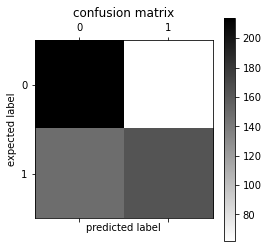

In [1323]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1324]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.59      0.78      0.67       276
        REAL       0.73      0.52      0.61       313

    accuracy                           0.64       589
   macro avg       0.66      0.65      0.64       589
weighted avg       0.66      0.64      0.64       589



# Logsitic Regression

In [1325]:
from sklearn.linear_model import LogisticRegression


In [1326]:
# bagging classifier

bagging_LR = BaggingClassifier(base_estimator=LogisticRegression(),
                         n_estimators=10, 
                        random_state=0)


In [1327]:
bagging_LR.fit(X_train_dtm, y_train)

BaggingClassifier(base_estimator=LogisticRegression(), random_state=0)

In [1328]:
bagging_LR.score(X_test_dtm,y_test)

0.7758913412563667

In [1329]:
y_pred_class=bagging_LR.predict(X_test_dtm)


In [1330]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[234,  42],
       [ 90, 223]])

In [1331]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 77.58913412563668


Text(0.5, 0, 'predicted label')

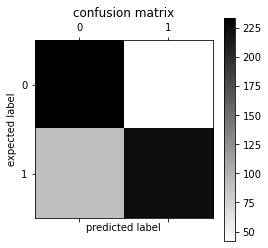

In [1332]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1333]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.72      0.85      0.78       276
        REAL       0.84      0.71      0.77       313

    accuracy                           0.78       589
   macro avg       0.78      0.78      0.78       589
weighted avg       0.79      0.78      0.78       589



In [1334]:
scores = model_selection.cross_val_score(bagging_LR, X_train_dtm, y_train, cv = kfold)


## AdaBoosting LR

In [1335]:
from sklearn.ensemble import AdaBoostClassifier

In [1336]:
adaboosting_LR = AdaBoostClassifier(base_estimator=LogisticRegression(),
                         n_estimators=500, 
                        learning_rate=1,
                        random_state=0)

In [1337]:
adaboosting_LR.fit(X_train_dtm, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1,
                   n_estimators=500, random_state=0)

In [1338]:
y_pred_class=adaboosting_LR.predict(X_test_dtm)


In [1339]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[233,  43],
       [ 90, 223]])

In [1340]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 77.41935483870968


Text(0.5, 0, 'predicted label')

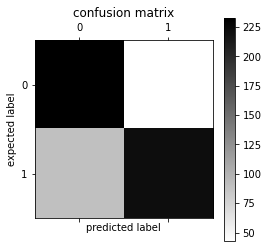

In [1341]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1342]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.72      0.84      0.78       276
        REAL       0.84      0.71      0.77       313

    accuracy                           0.77       589
   macro avg       0.78      0.78      0.77       589
weighted avg       0.78      0.77      0.77       589



## Gradient Boosting LR

In [1343]:
grdboosting_LR = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, 
                                            max_features=2, max_depth=2, random_state=0)

In [1344]:
grdboosting_LR.fit(X_train_dtm, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           random_state=0)

In [1345]:
metrics.confusion_matrix(y_test, y_pred_class)


array([[233,  43],
       [ 90, 223]])

In [1346]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)


Model Accuracy: 77.41935483870968


Text(0.5, 0, 'predicted label')

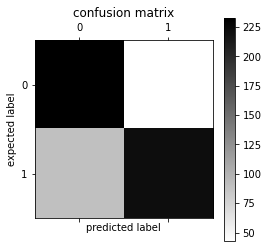

In [1347]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


In [1348]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.72      0.84      0.78       276
        REAL       0.84      0.71      0.77       313

    accuracy                           0.77       589
   macro avg       0.78      0.78      0.77       589
weighted avg       0.78      0.77      0.77       589



# Decision Tree

In [1349]:
seed = 8
kfold = model_selection.KFold(n_splits = 3,
                              shuffle = True,
                       random_state = seed)

In [1350]:
# initialize the base classifier

base_cls = DecisionTreeClassifier()

In [1351]:
# bagging classifier

bagging_DT = BaggingClassifier(base_estimator = base_cls,
                          n_estimators = 10,
                          random_state = seed)


In [1352]:
bagging_DT.fit(X_train_dtm, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=8)

In [1353]:
y_pred_class=bagging_DT.predict(X_test_dtm)

In [1354]:
metrics.confusion_matrix(y_test, y_pred_class)


array([[249,  27],
       [153, 160]])

In [1355]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 69.43972835314092


Text(0.5, 0, 'predicted label')

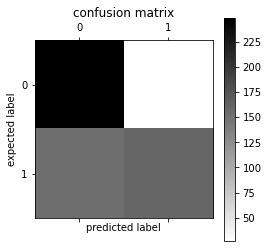

In [1356]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1357]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.62      0.90      0.73       276
        REAL       0.86      0.51      0.64       313

    accuracy                           0.69       589
   macro avg       0.74      0.71      0.69       589
weighted avg       0.74      0.69      0.68       589



In [1358]:
scores = model_selection.cross_val_score(bagging_DT, X_train_dtm, y_train, cv = kfold)


## AdaBoosting DT

In [1359]:
adaboosting_DT = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                         n_estimators=100, 
                        learning_rate=1,
                        random_state=seed)

In [1360]:
adaboosting_DT.fit(X_train_dtm,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=1,
                   n_estimators=100, random_state=8)

In [1361]:
y_pred_class = adaboosting_DT.predict(X_test_dtm)

In [1362]:
metrics.confusion_matrix(y_test, y_pred_class)


array([[215,  61],
       [ 97, 216]])

In [1363]:
# model accuracy
print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 73.1748726655348


Text(0.5, 0, 'predicted label')

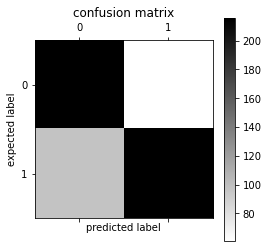

In [1364]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1365]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.69      0.78      0.73       276
        REAL       0.78      0.69      0.73       313

    accuracy                           0.73       589
   macro avg       0.73      0.73      0.73       589
weighted avg       0.74      0.73      0.73       589



## Gradient Boosting DT

In [1366]:
grdboosting_DT = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.25, 
                                            max_features=2, max_depth=2, random_state=0)

In [1367]:
grdboosting_DT.fit(X_train_dtm, y_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=2, max_features=2,
                           n_estimators=1000, random_state=0)

In [1368]:
y_pred_class=grdboosting_DT.predict(X_test_dtm)

In [1369]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[222,  54],
       [117, 196]])

In [1370]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 70.96774193548387


Text(0.5, 0, 'predicted label')

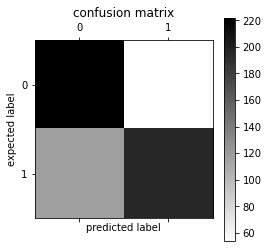

In [1371]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1372]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.65      0.80      0.72       276
        REAL       0.78      0.63      0.70       313

    accuracy                           0.71       589
   macro avg       0.72      0.72      0.71       589
weighted avg       0.72      0.71      0.71       589



# Random Forest

In [1373]:
# define model
bagging_RF = RandomForestClassifier(n_estimators=10)

In [1374]:
bagging_RF.fit(X_train_dtm, y_train)


RandomForestClassifier(n_estimators=10)

In [1375]:
y_pred_class = bagging_RF.predict(X_test_dtm)


In [1376]:
metrics.confusion_matrix(y_test, y_pred_class)


array([[246,  30],
       [159, 154]])

In [1377]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 67.91171477079796


Text(0.5, 0, 'predicted label')

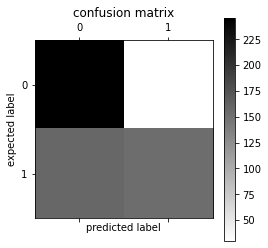

In [1378]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1379]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.61      0.89      0.72       276
        REAL       0.84      0.49      0.62       313

    accuracy                           0.68       589
   macro avg       0.72      0.69      0.67       589
weighted avg       0.73      0.68      0.67       589



In [1380]:
# evaluate model

scores = model_selection.cross_val_score(bagging_RF, X_train_dtm,y_train, scoring='roc_auc', cv=5, n_jobs=-1)

## AdaBoosting RF

In [1381]:
## Adaboosting
adaboosting_RF = AdaBoostClassifier(n_estimators=500)

In [1382]:
adaboosting_RF.fit(X_train_dtm, y_train)


AdaBoostClassifier(n_estimators=500)

In [1383]:
y_pred_class = adaboosting_RF.predict(X_test_dtm)


In [1384]:
metrics.confusion_matrix(y_test, y_pred_class)


array([[233,  43],
       [110, 203]])

In [1385]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 74.02376910016977


Text(0.5, 0, 'predicted label')

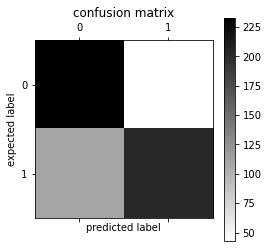

In [1386]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1387]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.68      0.84      0.75       276
        REAL       0.83      0.65      0.73       313

    accuracy                           0.74       589
   macro avg       0.75      0.75      0.74       589
weighted avg       0.76      0.74      0.74       589



## Gradient Boosting RF

In [1388]:
grdboosting_RF = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5, 
                                            max_features=2, max_depth=2, random_state=0)

In [1389]:
grdboosting_RF.fit(X_train_dtm, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           n_estimators=1000, random_state=0)

In [1390]:
y_pred_class=grdboosting_RF.predict(X_test_dtm)

In [1391]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[214,  62],
       [117, 196]])

In [1392]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 69.60950764006792


Text(0.5, 0, 'predicted label')

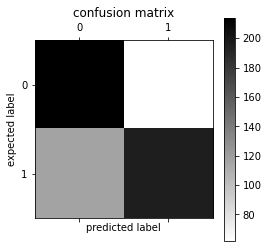

In [1393]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1394]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.65      0.78      0.71       276
        REAL       0.76      0.63      0.69       313

    accuracy                           0.70       589
   macro avg       0.70      0.70      0.70       589
weighted avg       0.71      0.70      0.70       589



#  Bagging SVC

In [1395]:
from sklearn.svm import SVC

In [1396]:
# bagging classifier

bagging_SVC = BaggingClassifier(base_estimator=SVC(),
                         n_estimators=10, 
                        random_state=0)

In [1397]:
bagging_SVC.fit(X_train_dtm, y_train)



BaggingClassifier(base_estimator=SVC(), random_state=0)

In [1398]:
y_pred_class = bagging_SVC.predict(X_test_dtm)


In [1399]:
metrics.confusion_matrix(y_test, y_pred_class)


array([[223,  53],
       [ 98, 215]])

In [1400]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 74.36332767402376


Text(0.5, 0, 'predicted label')

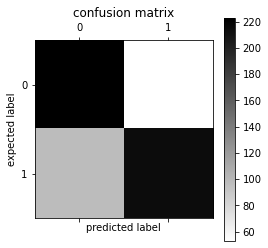

In [1401]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1402]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.69      0.81      0.75       276
        REAL       0.80      0.69      0.74       313

    accuracy                           0.74       589
   macro avg       0.75      0.75      0.74       589
weighted avg       0.75      0.74      0.74       589



In [1403]:
scores = model_selection.cross_val_score(bagging_SVC, X_train_dtm, y_train, cv = 5)


## AdaBoosting SVC

In [1404]:
# AdaBoosting SVC
from sklearn.ensemble import AdaBoostClassifier



In [1405]:
svc=SVC(probability=True, kernel='linear')


In [1406]:
adaboosting_SVC = AdaBoostClassifier(base_estimator=svc,
                         n_estimators=500, 
                        learning_rate=1,
                        random_state=0)

In [1407]:
model = adaboosting_SVC.fit(X_train_dtm, y_train)


In [1408]:
y_pred = model.predict(X_test_dtm)


In [1409]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)


Accuracy: 78.26825127334465


Text(0.5, 0, 'predicted label')

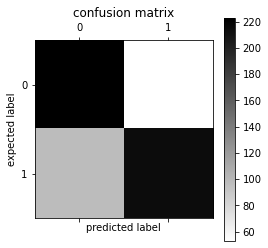

In [1410]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1411]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        FAKE       0.73      0.86      0.79       276
        REAL       0.85      0.72      0.78       313

    accuracy                           0.78       589
   macro avg       0.79      0.79      0.78       589
weighted avg       0.79      0.78      0.78       589



## Gradient Boosting SVC

In [1412]:
grdboosting_SVC = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5, 
                                            max_features=2, max_depth=2, random_state=1)



In [1413]:
grdboosting_SVC.fit(X_train_dtm, y_train)


GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           n_estimators=1000, random_state=1)

In [1414]:
y_pred_class=grdboosting_SVC.predict(X_test_dtm)

In [1415]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[213,  63],
       [ 95, 218]])

In [1416]:
# model accuracy

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred_class)*100)

Model Accuracy: 73.1748726655348


Text(0.5, 0, 'predicted label')

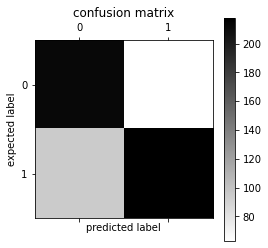

In [1417]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1418]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.69      0.77      0.73       276
        REAL       0.78      0.70      0.73       313

    accuracy                           0.73       589
   macro avg       0.73      0.73      0.73       589
weighted avg       0.74      0.73      0.73       589



## Voting Classifier

In [1419]:
from sklearn.ensemble import  VotingClassifier


In [1420]:
def get_voting():
    models = []
    models.append(('nb', MultinomialNB(max_depth=1)))
    models.append(('rf', RandomForestClassifier(n_estimators=50, random_state=1, max_depth =2)))
    models.append(('lr', LogisticRegression(multi_class='multinomial',random_state=1)))
    models.append(('dt', DecisionTreeRegressor(max_depth=2)))
    models.append(('svc', SVC(max_depth=5)))
    votingclf = VotingClassifier(estimators=[
            ('nb',nb),('lr', lr), ('rf', rf), ('dt', dt),('svc',svc)], voting='hard')
    return votingclf

In [1421]:
def get_models():
    models = dict()
    models['nb'] = MultinomialNB(max_depth=1)
    models['lr'] = LogisticRegression(max_depth=2)
    models['rf'] = RandomForestClassifier(max_depth=3)
    models['dt'] = DecisionTreeRegressor(max_depth=4)
    models['svc'] = SVC(max_depth=5)
    models['voting'] = get_voting()
    return models


In [1422]:
votingclf.fit(X_train_dtm, y_train)

VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=2,
                                                     n_estimators=50,
                                                     random_state=1)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=1)),
                             ('svc', SVC())])

In [1423]:
y_pred_class = votingclf.predict(X_test_dtm)
score = metrics.accuracy_score(y_test, y_pred_class)
# score = votingclf.score(X_test_dtm, y_test)
score

0.7538200339558574

In [1424]:
# names = ["SVC", "NB", "Decision Tree", "Random Forest", "Logistic Regression", "voting"]
classifiers = [svc, nb, dt, rf, lr, votingclf]

Text(0.5, 0, 'predicted label')

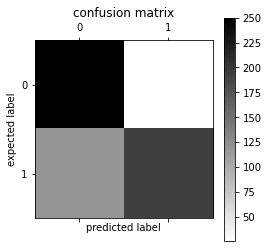

In [1427]:
plt.matshow(confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [1428]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

        FAKE       0.68      0.91      0.78       276
        REAL       0.88      0.62      0.73       313

    accuracy                           0.75       589
   macro avg       0.78      0.76      0.75       589
weighted avg       0.79      0.75      0.75       589



In [1429]:
# votingclf2 = VotingClassifier(estimators=[
#             ('nb',nb),('lr', lr), ('rf', rf), ('dt', dt),('svc',svc)], voting='soft')

In [1430]:
# votingclf2.fit(X_train_dtm, y_train)

In [1431]:
# y_pred_class = votingclf2.predict(y_train)
# score = metrics.accuracy_score(y_test, y_pred_class)
# # score = votingclf.score(X_test_dtm, y_test)
# score

In [1475]:
from sklearn.model_selection import StratifiedKFold

In [1476]:
models1 = []
models1.append(('LR', BaggingClassifier(LogisticRegression())))
models1.append(('NB', BaggingClassifier(MultinomialNB())))
models1.append(("DT",BaggingClassifier(DecisionTreeClassifier())))
models1.append(('RF',BaggingClassifier(RandomForestClassifier())))
models1.append(('SVM', SVC()))
scoring1='accuracy'
results1=[]
names1=[]

In [1478]:
for name, model in models1:
    kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)
    scores = model_selection.cross_val_score(model, X_train_dtm, y_train, cv=kfold, scoring=scoring)
    results1.append(scores)
    names1.append(name)
    msg = "%s: %f (%f)" % (name, scores.mean(), scores.std())
    print(msg)


LR: 0.787394 (0.023851)
NB: 0.766423 (0.032011)
DT: 0.734107 (0.028153)
RF: 0.746010 (0.034075)
SVM: 0.765296 (0.028570)


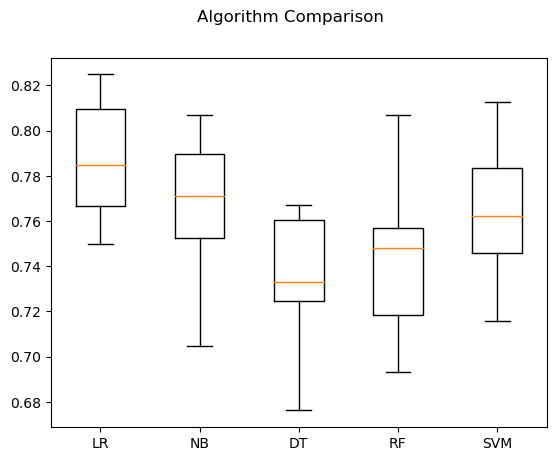

In [1479]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results1)
ax.set_xticklabels(names1)
plt.show()

In [1462]:
models = []
models.append(('LR', AdaBoostClassifier(LogisticRegression())))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', AdaBoostClassifier(MultinomialNB())))
models.append(("DT",AdaBoostClassifier(DecisionTreeClassifier())))
models.append(('RF',AdaBoostClassifier(RandomForestClassifier())))
models.append(('SVM', AdaBoostClassifier(SVC())))
scoring='accuracy'
results=[]
names=[]

In [1466]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)
    scores = model_selection.cross_val_score(model, X_train_dtm, y_train, cv=kfold, scoring=scoring)
    results.append(scores)
    names.append(name)
    msg = "%s: %f (%f)" % (name, scores.mean(), scores.std())
    

/Users/dudyalavikramcharan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dudyalavikramcharan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dudyalavikramcharan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "/Users/dudyalavikramcharan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py", line 117, in fit
    self._validate_estimator()
  File "/Users/dudyalavikramcharan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py", line 453, in _validate_estimator
    raise TypeError(
TypeError: AdaB

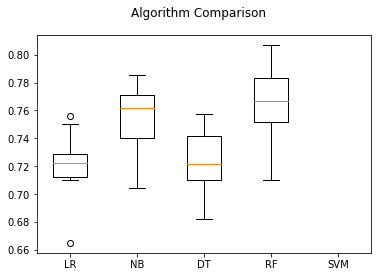

In [1438]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()